# CLASSIFICATION

### CLASSIFICATION PLAN:
We collected the labelled data from 2 different origins:
1. **KMeans Clustering** result (which will be called **original data**): 3 distinct classes, one of which is highly **imbalanced**
2. **Fuzzy Kmeans Clustering** result (which will be called **fuzzy data**): 3 distinct classes, not on same magnitude but also not particularly imbalanced

Different approaches will be evaluated:
* Apply classification on original train set i.e. high imbalance in data
* Apply classification on oversampled original train set (robust oversampling method -> SMOTE)
* Apply classification on oversampled original train set and test set (robust oversampling method -> SMOTE)
* Apply classification on fuzzy train set i.e. more balanced data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import pydotplus 
from IPython.display import Image 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

***

In [2]:
# UTILITY FUNCTIONS

# transform categorical attributes in numerical (all thanks and credits to Francesca, useful function!)
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

# pretty printing of metrics computed on test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes, zero_division=0)) 
# (to avoid exagerated warnings) zero division = 0 makes sure that no warnings are raised even if no classification on a certain class happens (and it can happen in multiple cases in this notebook)

***

# WORKING ON ORIGINAL DATA

***

In [3]:
# Starting dataset
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MeanTimeGap     4333 non-null   float64
 13  MaxOrderMonth   4333 non-null   object 
 14  MaxOrderDay     4333 non-null   object 
 15  Label           4333 non-null   object 
dtypes: float64(9), int64(4), object(3)
memory usage: 575.5+ KB


In [4]:
# taking a look at data distribution between classes
for label in df['Label'].unique():
    print(label,"elements in dataset:",len(df[df['Label'] == label]))

Low_Spend elements in dataset: 3867
Med_Spend elements in dataset: 440
High_Spend elements in dataset: 26


In [5]:
# we only have 2 categorical attributes, discretize them and get rid of them (also get rid of attributes which lead in our experiments to bad classification)
df = discretize_data(df,['MaxOrderMonth','MaxOrderDay','Label'])
df.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,MeanTimeGap,MaxOrderMonth_num,MaxOrderDay_num,Label_num
CustomerID,,,,,,,,,,,,
13436,76,12,76.0,196.89,196.89,0,5.830,1,0.0,2,3,1
15520,314,18,314.0,343.50,343.50,0,1.724,1,0.0,2,3,1
13298,96,2,96.0,360.00,360.00,0,3.750,1,0.0,2,3,1
14569,79,10,79.0,227.39,227.39,0,3.920,1,0.0,2,3,1
12713,505,37,505.0,794.55,794.55,0,2.085,1,0.0,2,0,2


In [6]:
# we keep true labels apart
label = df_class.pop('Label_num')
# we split dataset in train and test dataset. The use of stratify assures we keep correct class proportions in train and test
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify = label, test_size=0.30)

***

## CLASSIFICATION on ORIGINAL TRAIN SET

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [7]:
# parameters based on various trial and errors
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

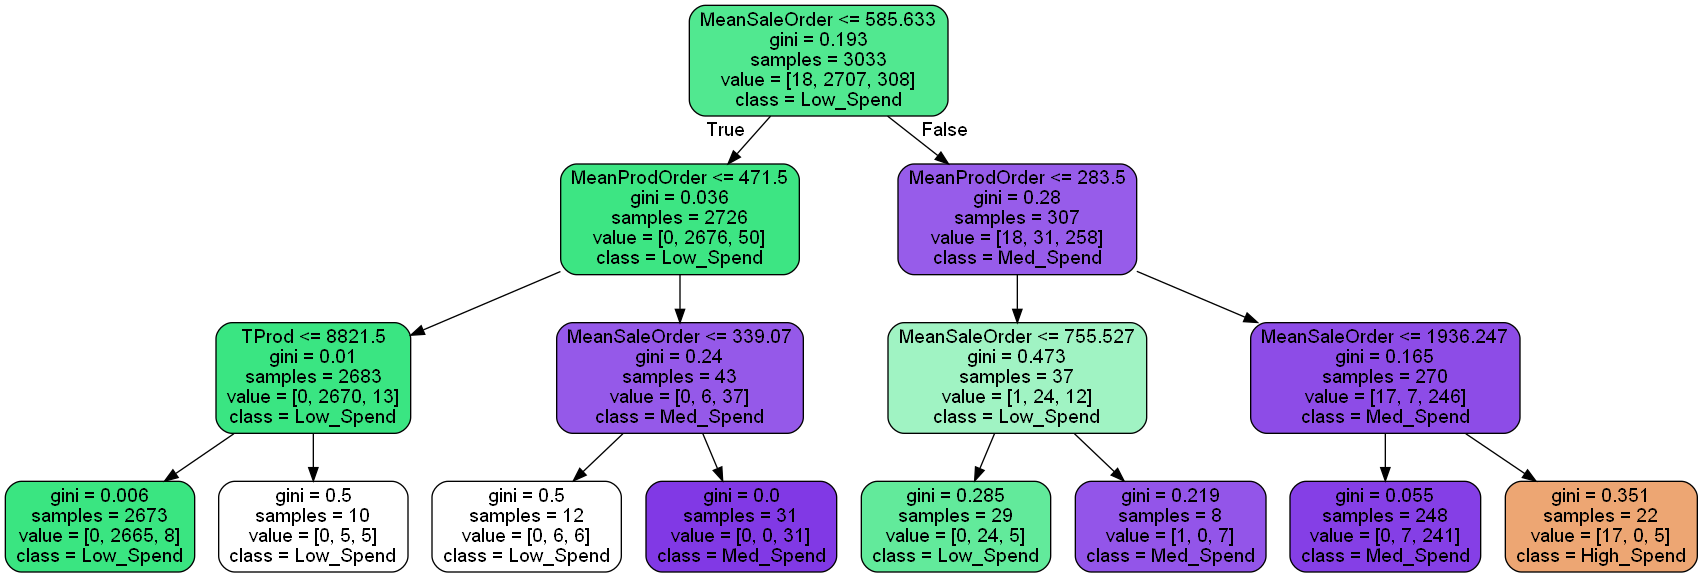

In [8]:
# visualization of dt 
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
# predict and evaluate results on train and test set
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.987800857237059
Accuracy test set  0.9823076923076923
Precision train set  0.9879569748734307
Recall train set  0.987800857237059
F1 score train set  0.9877004868420363
Support train set  (array([0.77272727, 0.99118943, 0.97212544]), array([0.94444444, 0.99741411, 0.90584416]), array([0.85      , 0.99429203, 0.93781513]), array([  18, 2707,  308], dtype=int64))


In [10]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.67      0.75      0.71         8
   Low_Spend       0.99      1.00      0.99      1160
   Med_Spend       0.97      0.86      0.91       132

    accuracy                           0.98      1300
   macro avg       0.87      0.87      0.87      1300
weighted avg       0.98      0.98      0.98      1300



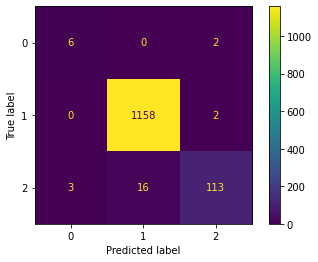

In [11]:
# plot confusion matrix
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

### Random Forest

**First do a grid search for correct parameter setting**

In [12]:
# define the parameter ranges we want to try, then run the grid search
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=num_estimators)
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439460>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439880>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439700>},
                   scoring=make_scorer(accuracy_score))

In [13]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 8}
Mean and std of this setting  0.9874707075320381 0.003984488518856628


In [14]:
# set and train the specified random forest
rf = RandomForestClassifier(n_estimators=30, 
                             criterion=grid_search.cv_results_['params'][0]['criterion'],
                             max_features=grid_search.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search.cv_results_['params'][0]['bootstrap']) 
rf = rf.fit(train_set, train_label)

In [15]:
# predict on test and visualize results
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.62      0.77         8
   Low_Spend       0.99      1.00      1.00      1160
   Med_Spend       0.97      0.94      0.95       132

    accuracy                           0.99      1300
   macro avg       0.99      0.85      0.91      1300
weighted avg       0.99      0.99      0.99      1300



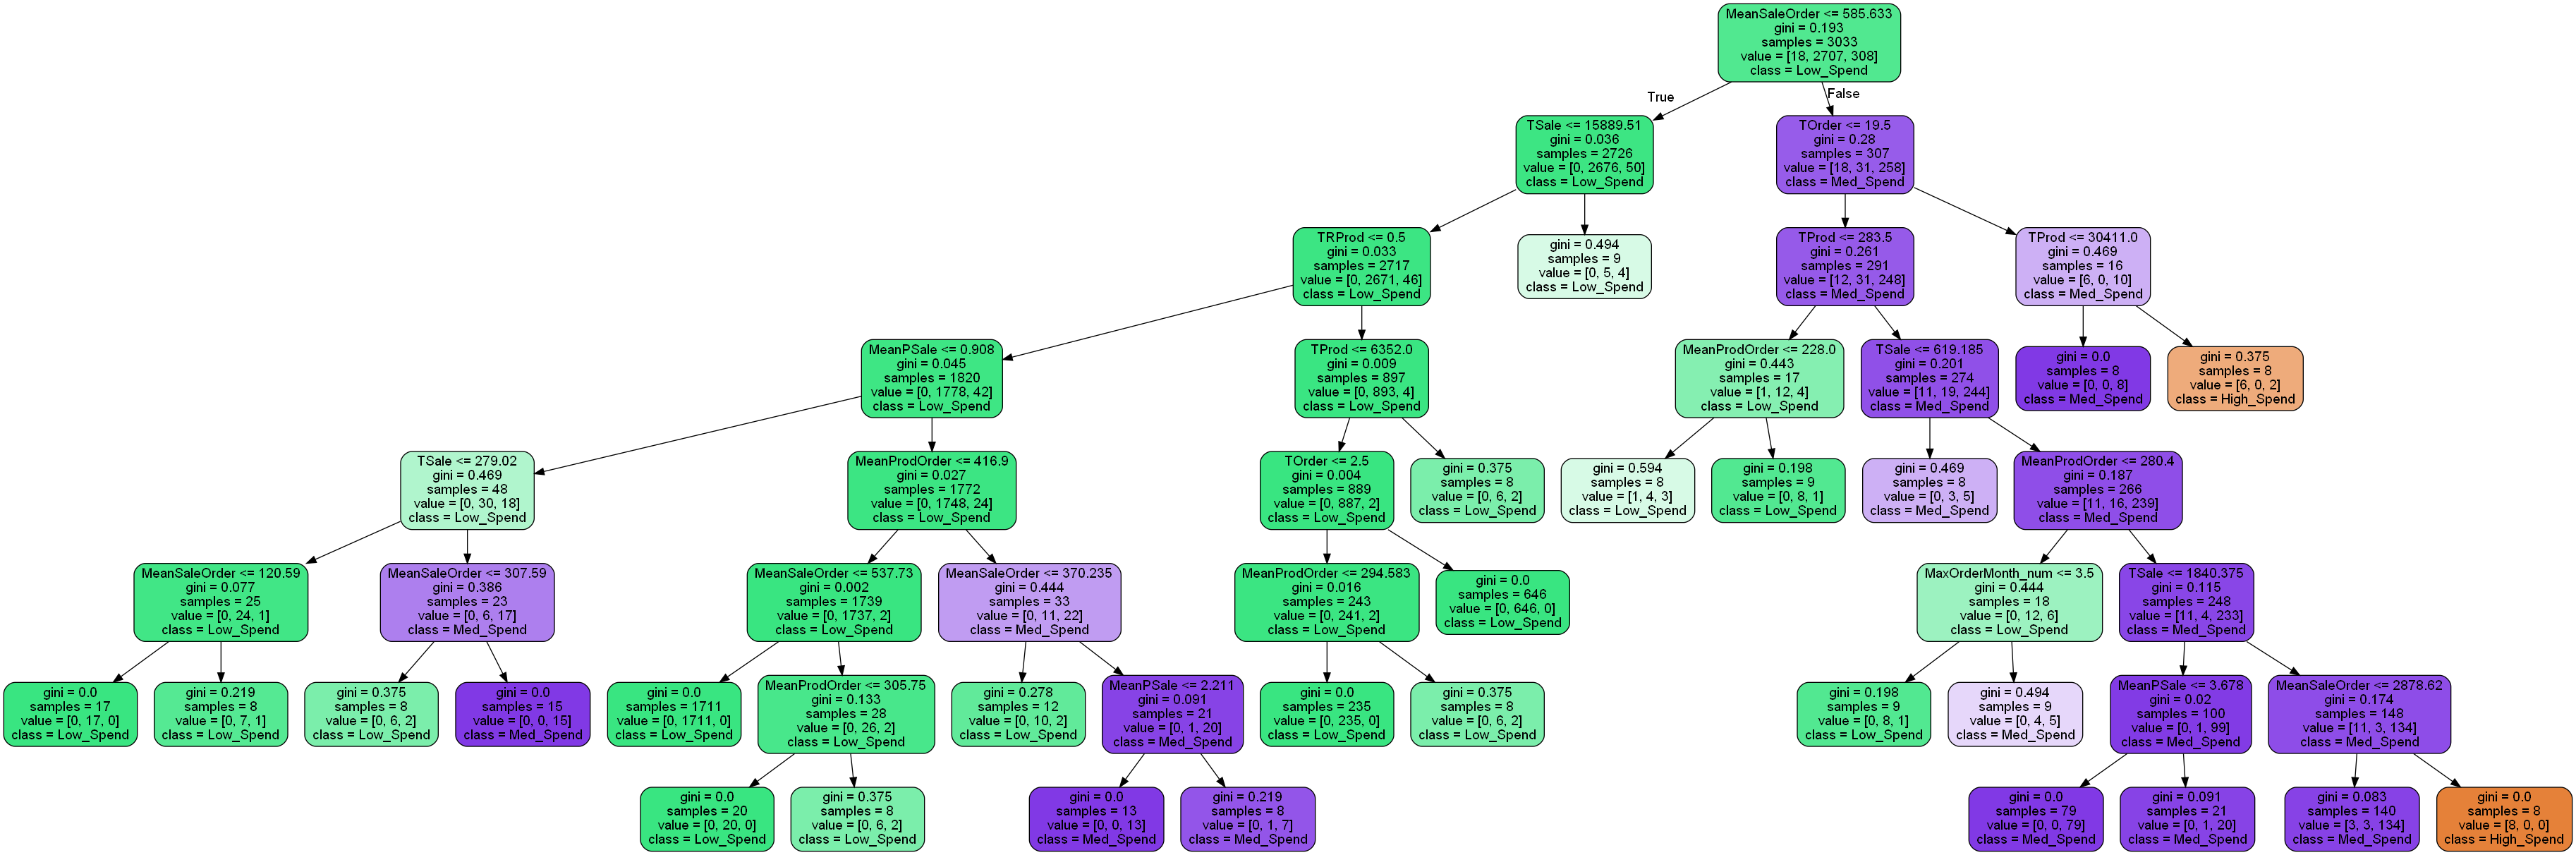

In [16]:
# forest is composed of lots of dt, visualize one just for fun
dot_data = tree.export_graphviz(rf[0], out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Naive Bayes

In [17]:
# define and fit gaussian model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.37      0.88      0.52         8
   Low_Spend       0.97      0.95      0.96      1160
   Med_Spend       0.65      0.68      0.66       132

    accuracy                           0.93      1300
   macro avg       0.66      0.84      0.71      1300
weighted avg       0.93      0.93      0.93      1300



### KNN

In [18]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.25      0.40         8
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.89      0.82      0.85       132

    accuracy                           0.97      1300
   macro avg       0.95      0.69      0.75      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [19]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.91      0.99      0.95      1160
   Med_Spend       0.74      0.17      0.28       132

    accuracy                           0.91      1300
   macro avg       0.55      0.39      0.41      1300
weighted avg       0.89      0.91      0.88      1300



***

## CLASSIFICATION on OVERSAMPLED TRAIN SET (SMOTE)

**SMOTE** is a different stratification method which applies oversampling to the classes. The difference between this method and the basic oversampling applied before stands in the generation of new data:
* in the basic oversampling, original data is simply copied to create exact (but additional) new data
* in SMOTE oversampling, original data is used to create new data which copies the old one adding a [0,1] **perturbation**, hence generating truly new data

In [20]:
# create oversampled data
strat = {1: Counter(train_label)[1], 2: Counter(train_label)[2], 0: Counter(train_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)

train_set_smote, train_label_smote = smote.fit_resample(train_set, train_label)

In [21]:
# visualize data distribution
Counter(train_label_smote)

Counter({1: 2707, 2: 308, 0: 308})

### Random Forest

Try grid search again, on this more **balanced** dataset

In [22]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439460>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439880>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439700>},
                   scoring=make_scorer(accuracy_score))

In [23]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'min_samples_leaf': 16, 'min_samples_split': 5}
Mean and std of this setting  0.9885650874173384 0.006059268235300387


In [24]:
# set and train the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [25]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.75      0.75      0.75         8
   Low_Spend       0.99      0.99      0.99      1160
   Med_Spend       0.94      0.91      0.92       132

    accuracy                           0.98      1300
   macro avg       0.89      0.88      0.89      1300
weighted avg       0.98      0.98      0.98      1300



### Naive Bayes

In [26]:
# define and fit gaussian model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.33      0.88      0.48         8
   Low_Spend       0.97      0.95      0.96      1160
   Med_Spend       0.66      0.68      0.67       132

    accuracy                           0.93      1300
   macro avg       0.65      0.84      0.70      1300
weighted avg       0.93      0.93      0.93      1300



### KNN

In [27]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.50      0.75      0.60         8
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.91      0.77      0.84       132

    accuracy                           0.97      1300
   macro avg       0.80      0.84      0.81      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [28]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.07      1.00      0.14         8
   Low_Spend       0.92      0.94      0.93      1160
   Med_Spend       0.00      0.00      0.00       132

    accuracy                           0.85      1300
   macro avg       0.33      0.65      0.35      1300
weighted avg       0.82      0.85      0.83      1300



***

## CLASSIFICATION on OVERSAMPLED TRAIN SET and TEST SET (SMOTE)

In [29]:
# before starting classification we apply stratification to test set to have more data in less populated class
# we do this because otherwise our test set would be populated of < 10 elements for High_Spend class, giving a susceptible evaluation  
strat = {1: Counter(test_label)[1], 2: Counter(test_label)[2], 0: Counter(test_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)
test_set, test_label = smote.fit_resample(test_set, test_label)

# visualize data distribution in TEST
Counter(test_label)

Counter({1: 1160, 0: 132, 2: 132})

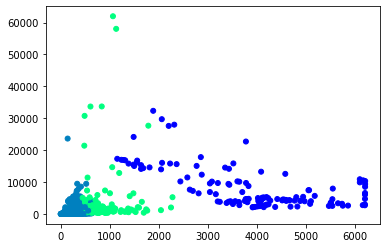

In [30]:
plt.scatter(test_set.iloc[:, 4].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

In [31]:
Counter(train_label_smote)

Counter({1: 2707, 2: 308, 0: 308})

### Random Forest

Try grid search again, on this more balanced dataset

In [32]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439460>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439880>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439700>},
                   scoring=make_scorer(accuracy_score))

In [33]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 10, 'min_samples_split': 8}
Mean and std of this setting  0.9891674970558928 0.0034802099311851604


In [34]:
# set and train the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [35]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.97      0.89      0.93       132
   Low_Spend       0.99      1.00      0.99      1160
   Med_Spend       0.87      0.91      0.89       132

    accuracy                           0.98      1424
   macro avg       0.95      0.93      0.94      1424
weighted avg       0.98      0.98      0.98      1424



### Naive Bayes

In [36]:
# define and fit gaussian model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.89      0.89      0.89       132
   Low_Spend       0.97      0.95      0.96      1160
   Med_Spend       0.60      0.68      0.64       132

    accuracy                           0.92      1424
   macro avg       0.82      0.84      0.83      1424
weighted avg       0.93      0.92      0.92      1424



### KNN

In [37]:
# define and fit gaussian model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.94      0.67      0.78       132
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.66      0.77      0.71       132

    accuracy                           0.94      1424
   macro avg       0.86      0.81      0.83      1424
weighted avg       0.95      0.94      0.94      1424



### SVM

In [38]:
# define and fit gaussian model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.56      1.00      0.72       132
   Low_Spend       0.92      0.94      0.93      1160
   Med_Spend       0.00      0.00      0.00       132

    accuracy                           0.86      1424
   macro avg       0.49      0.65      0.55      1424
weighted avg       0.80      0.86      0.82      1424



***

# WORKING ON FUZZY DATA

In [39]:
# Starting dataset
df_f = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)

In [40]:
# we only have 2 categorical attributes, discretize them and get rid of them (also get rid of attributes which lead in our experiments to bad classification)
df_f = discretize_data(df_f,['MaxOrderMonth','MaxOrderDay','Label'])
df_f.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df_f.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_f_class = df_f.copy()

In [41]:
# we keep true labels apart
label = df_f_class.pop('Label_num')
# we split dataset in train and test dataset. The use of stratify assures we keep correct class proportions in train and test
train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_f_class, label, stratify = label, test_size=0.30)

***

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [42]:
# parameters based on various trial and errors
dt_f = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt_f = dt_f.fit(train_set_f, train_label_f)

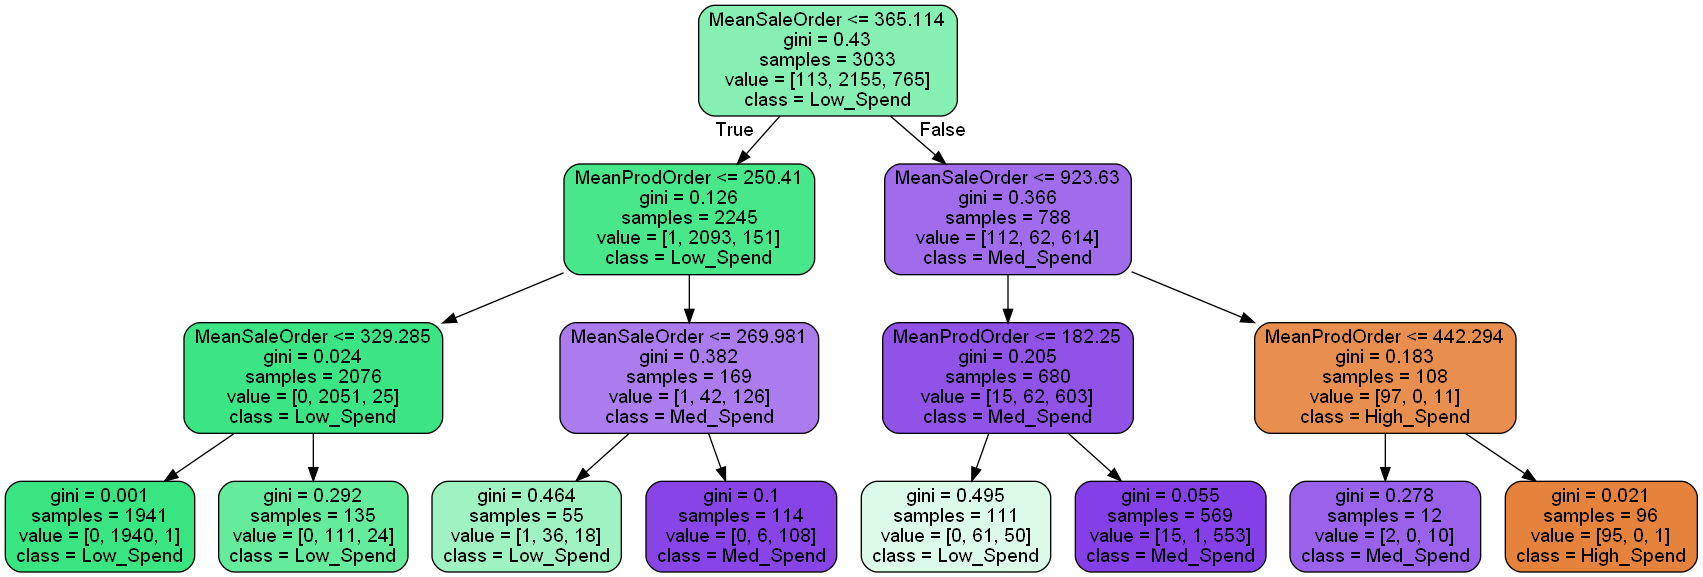

In [43]:
# visualization of dt
dot_data_f = tree.export_graphviz(dt_f, out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

In [44]:
# predict on train and test set
train_pred_dt_f = dt_f.predict(train_set_f)
test_pred_dt_f = dt_f.predict(test_set_f)

In [45]:
# visualize results
report_scores(test_label_f, test_pred_dt_f)

              precision    recall  f1-score   support

  High_Spend       0.98      0.82      0.89        49
   Low_Spend       0.94      0.99      0.97       923
   Med_Spend       0.95      0.84      0.89       328

    accuracy                           0.95      1300
   macro avg       0.96      0.88      0.92      1300
weighted avg       0.95      0.95      0.95      1300



### Random Forest

**Do a grid search for correct parameter setting**

In [46]:
# define the parameter ranges we want to try, then run the grid search
clf_f = RandomForestClassifier(n_estimators=30)
grid_search_f = RandomizedSearchCV(clf_f, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
grid_search_f.fit(train_set_f, train_label_f)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439460>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439880>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000016C05439700>},
                   scoring=make_scorer(accuracy_score))

In [47]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_f.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_f.cv_results_['mean_test_score'][0], 
      grid_search_f.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 11, 'min_samples_split': 17}
Mean and std of this setting  0.9683521729438184 0.0060046604691556095


In [48]:
# set and train the specified random forest
rf_f = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_f.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_f.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_f.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_f.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_f.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_f.cv_results_['params'][0]['bootstrap']) 
rf_f = rf_f.fit(train_set_f, train_label_f)

In [49]:
# predict on test and visualize results
test_pred_rf_f = rf_f.predict(test_set_f)
report_scores(test_label_f, test_pred_rf_f)

              precision    recall  f1-score   support

  High_Spend       1.00      0.78      0.87        49
   Low_Spend       0.98      0.98      0.98       923
   Med_Spend       0.91      0.95      0.93       328

    accuracy                           0.96      1300
   macro avg       0.96      0.90      0.93      1300
weighted avg       0.96      0.96      0.96      1300



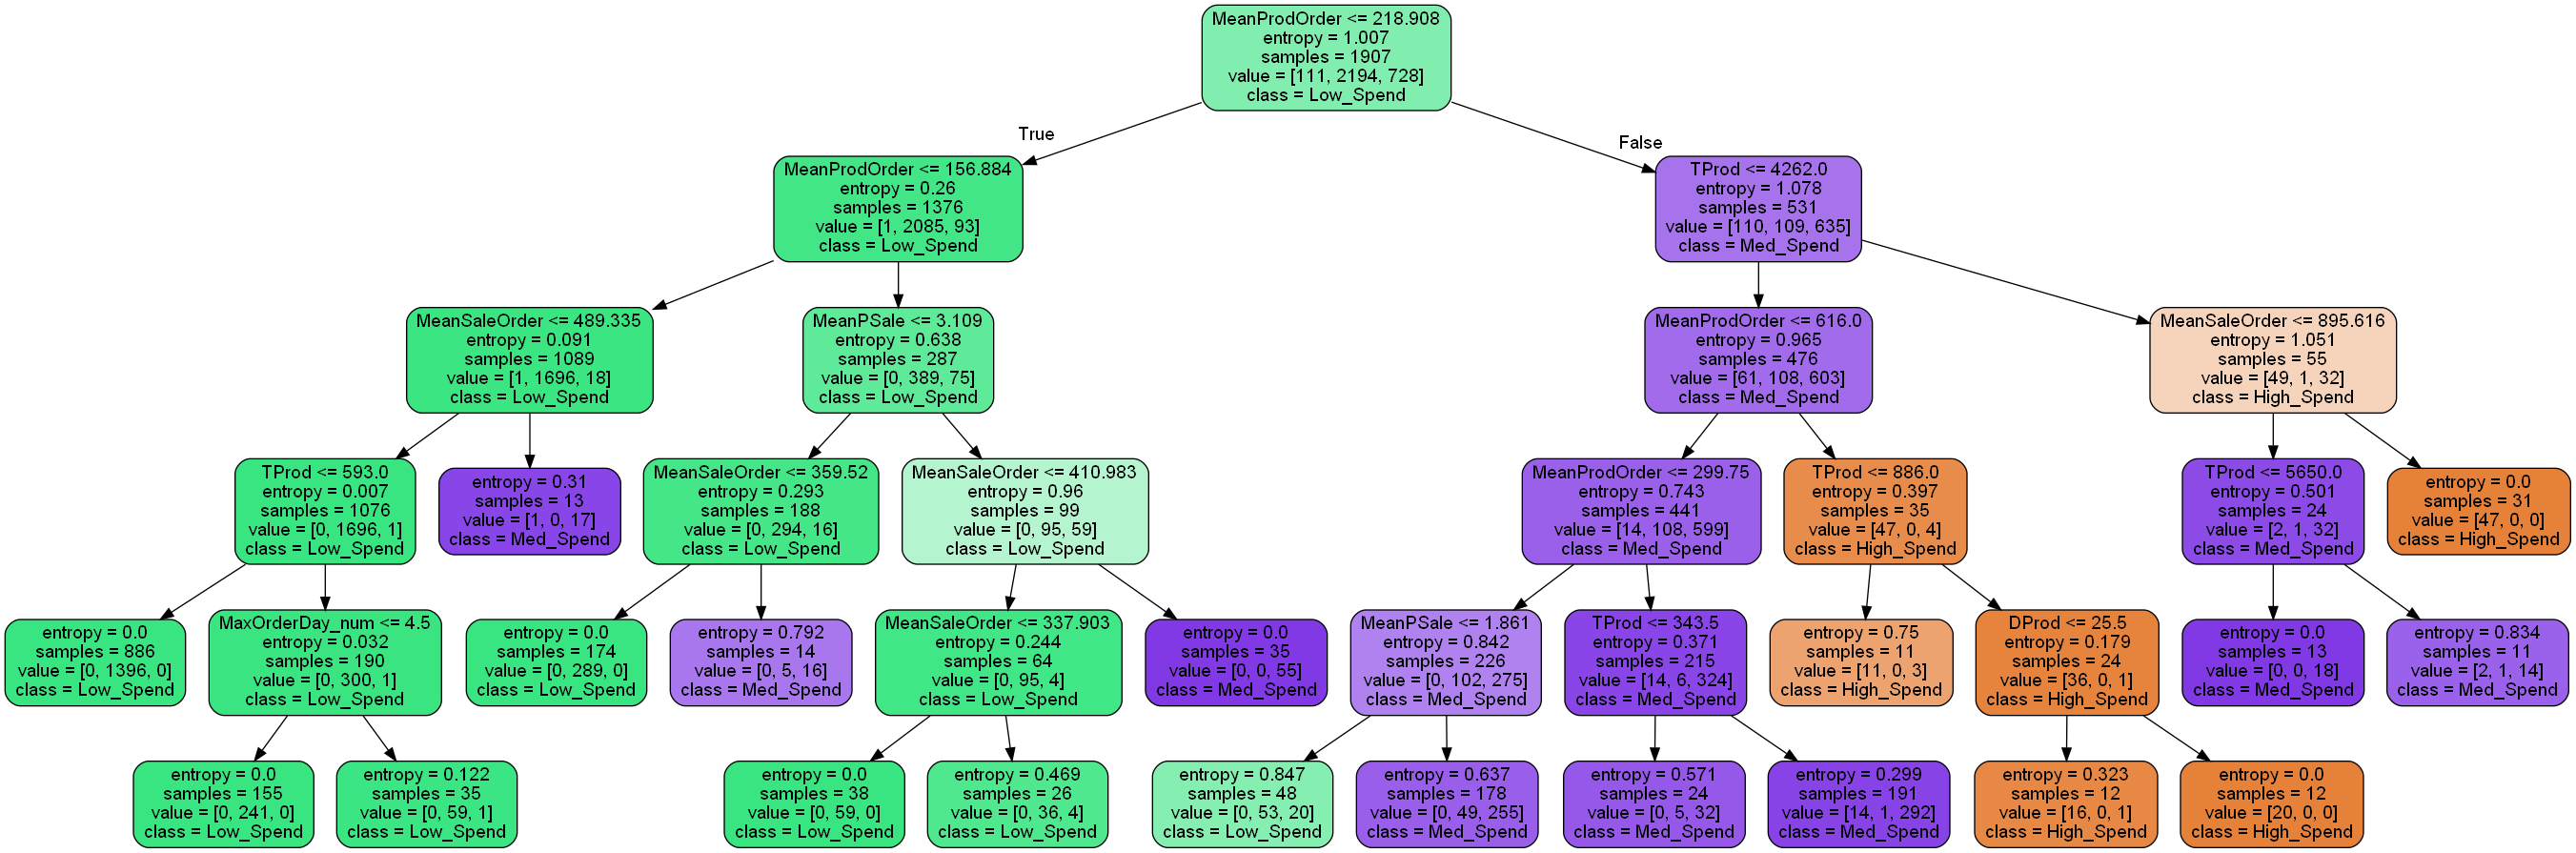

In [50]:
# forest is composed of lots of dt, visualize one just for fun
dot_data_f = tree.export_graphviz(rf_f[0], out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

### Naive Bayes

In [51]:
# define and fit gaussian model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_f, train_label_f)

test_pred_gnb = gnb.predict(test_set_f)

report_scores(test_label_f,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.64      0.65      0.65        49
   Low_Spend       0.95      0.96      0.95       923
   Med_Spend       0.84      0.81      0.83       328

    accuracy                           0.91      1300
   macro avg       0.81      0.81      0.81      1300
weighted avg       0.91      0.91      0.91      1300



### KNN

In [52]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_f, train_label_f)

test_pred_knn = knn.predict(test_set_f)

report_scores(test_label_f,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.90      0.76      0.82        49
   Low_Spend       0.96      0.97      0.96       923
   Med_Spend       0.87      0.87      0.87       328

    accuracy                           0.94      1300
   macro avg       0.91      0.87      0.89      1300
weighted avg       0.94      0.94      0.94      1300



### SVM

In [53]:
# define and fit knn model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_f, train_label_f)

test_pred_svm_f = svm.predict(test_set_f)

report_scores(test_label_f, test_pred_svm_f)

              precision    recall  f1-score   support

  High_Spend       0.34      0.22      0.27        49
   Low_Spend       0.78      0.96      0.86       923
   Med_Spend       0.47      0.20      0.28       328

    accuracy                           0.74      1300
   macro avg       0.53      0.46      0.47      1300
weighted avg       0.69      0.74      0.69      1300



***

# NEURAL NETWORK CLASSIFICATION

After trying many different approaches we decided to bring out the **big guns**

***

# A DIFFERENT APPROACH

Up to now we approached the classification using a set of features comprehensive of the same features used to create the labels: MeanProdOrder, MeanSaleOrder, MeanPSale, TProd. <br>What would happen if we decided to do without these features?

***

# END